## Todo:

1. Make box and whisker of ER per cluster

In [1]:
# %load_ext autoreload
# %autoreload 2
# from importlib import reload

import warnings
warnings.filterwarnings("ignore") # pandas is bugging me

import sys
import os
from enum import Enum
sys.path.append("src")
import operator
import pandas as pd

from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
import preprocessing.data_loading as data_loading
import models.rnn as rnn
import analysis.hit_rate_analysis as hit
import analysis.umap_analysis as umap
import umap.umap_ as do_umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from utils.utils import find_3mer

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, manifold, decomposition
from sklearn import metrics

import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.pyplot import cm
from tensorflow import keras
from scipy.spatial.distance import cdist

from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO

import subprocess
import logomaker as lm

In [2]:
class Y_AXIS_UNIT(Enum):
    COUNTS = 1
    BITS = 2


def muscle_align(seqs, seq_record_name, align_name):
    SeqIO.write(
        [SeqRecord(Seq(seq), id=seq) for seq in seqs],
        seq_record_name,
        "fasta",
    )
    subprocess.call(
        "muscle -super5 %s -output %s" % (seq_record_name, align_name),
        shell=True,
    )
    with open(align_name, "r") as f:
        raw_seqs = f.readlines()
    return [seq.strip() for seq in raw_seqs if ("#" not in seq) and (">") not in seq]


def save_web_logo_alignment(
    seqs,
    axis,
    save_to,
    seq_record_name="_example.fasta",
    align_name="_align.fasta",
    web_logo_name="logo.png",
    to_type="counts",
    align=True,
):
    if align:
        seqs = muscle_align(seqs, seq_record_name, align_name)
    counts_mat = lm.alignment_to_matrix(seqs, to_type=to_type)
    counts_mat.head()
    logo = lm.Logo(counts_mat, ax=axis, color_scheme="hydrophobicity")
    plt.savefig(os.path.join(save_to,web_logo_name))


def generate_weblogos_by_library(
    df, target_protein_name, title, save_to, y_axis_units=Y_AXIS_UNIT.BITS, library_count_threshold=1
):
    def peptide_passes(seq):
        cysteine_positions = [idx for idx, i in enumerate(seq) if i == "C"]
        # We only want completely linear sequences (no Cysteines)
        # Or well behaving macrocylcles (only 2 Cysteines)
        return len(cysteine_positions) == 0 or len(cysteine_positions) == 2

    def get_library_name(seq):
        cysteine_positions = [idx for idx, i in enumerate(seq) if i == "C"]
        if len(cysteine_positions) >= 2:
            return (
                "Macrocyclic "
                + str(len(seq))
                + "mers"
                + " w/ C's @ "
                + str(cysteine_positions)
            )
        else:
            # For Peptides with only 1 or 0 Cysteines, we should just treat them as linear
            return "Linear " + str(len(seq)) + "mers"

    df = df[df["Peptide"].apply(lambda seq: peptide_passes(seq))]
    # Create a key that takes into account len & cysteine placements within peptide
    macrocycle_idx_df = pd.DataFrame(
        df["Peptide"].apply(lambda seq: get_library_name(seq))
    )
    library_to_indices = macrocycle_idx_df.groupby("Peptide").indices
    # Collect Dict into a List & Sort by relevance, discard single library matches
    # (aka first element in library_and_seqs_list represents the most common library)
    library_and_seqs_list = sorted(
        [
            (lib, df["Peptide"].iloc[idxs])
            for lib, idxs in library_to_indices.items()
            if len(idxs) > library_count_threshold
        ],
        key=lambda tup: len(tup[1]),
        reverse=True,
    )
    fig, axs = plt.subplots(len(library_and_seqs_list), 1)

    try:
        for idx, (lib_name, seqs) in enumerate(library_and_seqs_list):
            axis = axs[idx]
            axis.set_title(
                lib_name + " (" + str(len(seqs)) + " peptides)",
                size=10,
            )
            axis.set_xticks([])
            if y_axis_units == Y_AXIS_UNIT.BITS:
                save_web_logo_alignment(save_to=save_to,
                    seqs=seqs, align=False, axis=axis, to_type="information"
                )
                axis.set_ylim([0,4])
            elif y_axis_units == Y_AXIS_UNIT.COUNTS:
                save_web_logo_alignment(save_to=save_to,seqs=seqs, align=False, axis=axis, to_type="counts")
    except TypeError:
        axs.set_title(
                lib_name + " (" + str(len(seqs)) + " peptides)",
                size=10,
            )
        axs.set_xticks([])
        if y_axis_units == Y_AXIS_UNIT.BITS:
            save_web_logo_alignment(save_to=save_to,
                seqs=seqs, align=False, axis=axs, to_type="information"
                )
            axs.set_ylim([0,4])
        elif y_axis_units == Y_AXIS_UNIT.COUNTS:
            save_web_logo_alignment(save_to=save_to, seqs=seqs, align=False, axis=axs, to_type="counts")

    fig.suptitle(target_protein_name + " Weblogos by Library", fontsize=15)
    fig.subplots_adjust(hspace=0.5)
    fig.add_subplot(111, frameon=False)
    # hide y & x tick labels of the big axis
    plt.tick_params(
        labelcolor="none",
        which="both",
        top=False,
        bottom=False,
        left=False,
        right=False,
    )
    plt.xlabel("Alignment Position")
    if y_axis_units == Y_AXIS_UNIT.BITS:
        plt.ylabel("Information (Bits)")
    elif y_axis_units == Y_AXIS_UNIT.COUNTS:
        plt.ylabel("Residue Positional Counts")
    name = target_protein_name + " Weblogos by Library" + title
    plt.savefig(os.path.join(save_to,name + '.png'),dpi=300)
    plt.show()

In [3]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")

protein_of_interest = "MDM2"
other_protein = "12ca5"

# y_raw is [pval, FC, ER]

X, y_raw, peptides = data_loading.build_joint_dataset(
    er_datafile =f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-mCDH2-R3.csv",
    protein_of_interest=protein_of_interest, 
    other_protein=other_protein
)

save_to = os.path.join('C:/','Users','Michael Lee','1 Phage Display Data','K means clustering')

rep_data = pd.DataFrame()
rep_data['X'] = [np.concatenate(x) for x in X]
rep_data['pval'] = [y[0] for y in y_raw]
rep_data['FC'] = [y[1] for y in y_raw]
rep_data['ER'] = [y[2] for y in y_raw]
rep_data['Peptide'] = peptides

rep_data_filtered = rep_data.query('pval > 2') # use pvalue cutoff of 0.01

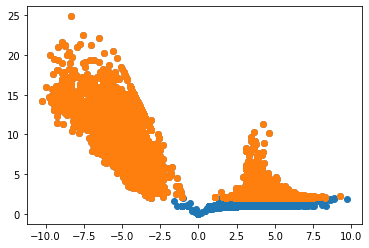

In [5]:
fig, ax = plt.subplots()
ax.scatter([a[1] for a in y_raw],[a[0] for a in y_raw])
ax.scatter(rep_data_filtered['FC'].to_list(),rep_data_filtered['pval'].to_list())

In [6]:
data_filtered = rep_data_filtered.merge(right = R3_lib, right_on = 'Peptide', left_on = 'Peptide')

X_format = data_filtered['X'].to_list()
peptides = data_filtered['Peptide'].to_list()

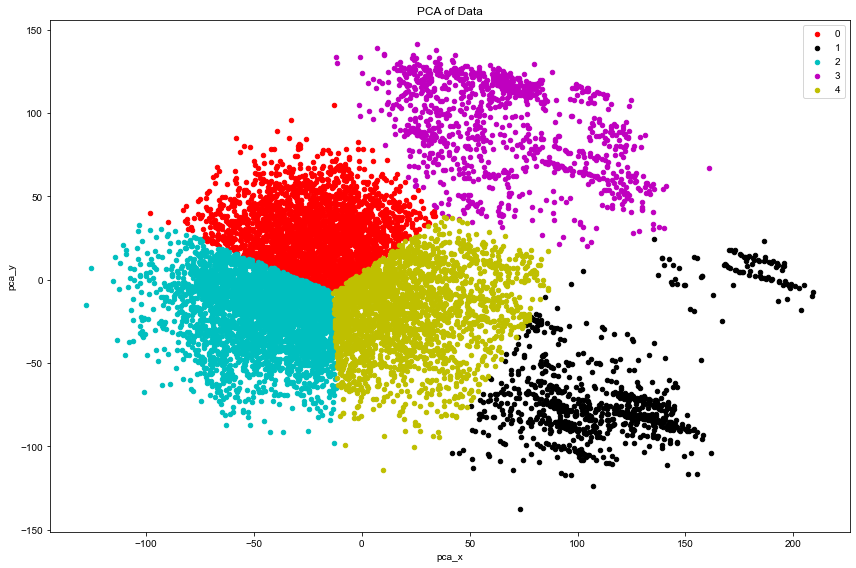

In [11]:
n_clusters = 5
SEED = 69
colors = ['r','k','c','m','y']

reducer_scaled_dict = {}
embedding_scaled_dict = {}

pca = decomposition.PCA(n_components=2, random_state=SEED)
embedding = pca.fit_transform(X_format)

pca_fn = pca
pca_embedding = embedding

clusterer = Pipeline(
    [
        ('kmeans',
         KMeans(
             n_clusters = n_clusters,
             init = 'k-means++',
             n_init = 50,
             max_iter = 500,
             random_state = 69))])

pipe = Pipeline(
    [
        ('clusterer',clusterer)
    ])
# most rigorous pipeline NA    

out = pipe.fit(pca_embedding)

clusters = out['clusterer'].transform(pca_embedding)
labels = out['clusterer']['kmeans'].labels_
groups = np.unique(labels)

data_filtered['pca_x'] = pca_embedding[:,0]
data_filtered['pca_y'] = pca_embedding[:,1]
data_filtered['pca label'] = labels

fig,ax = plt.subplots(1,1,figsize=(12,8))
for l in np.unique(labels):
    df_sub = data_filtered.query('`pca label` == @l')
    df_sub.plot.scatter(x = 'pca_x', y = 'pca_y',c=colors[l],ax=ax)
ax.set_title(f'PCA of Data')
ax.legend(['0','1','2','3','4'],loc='best')
fig.tight_layout()
fig.show()

<AxesSubplot:xlabel='FC', ylabel='pval'>

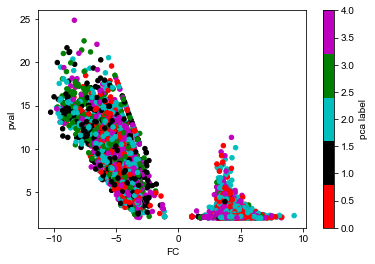

In [12]:
cmap = ListedColormap(['r','k','c','g','m']) # lol
fig, ax = plt.subplots()
data_filtered.plot.scatter(x = 'FC', y = 'pval', c = 'pca label', colormap=cmap, ax = ax)

In [13]:
%%time

n_neighbors = 12  # want 2**n_neighbors to be around 5% of total data

reducer_scaled = do_umap.UMAP(
    n_components=2, n_neighbors=2**n_neighbors, 
    random_state=SEED, metric='rogerstanimoto')
embedding_scaled = reducer_scaled.fit_transform(X_format)

umap_fn = reducer_scaled
umap_embedding = embedding_scaled

Wall time: 26min 19s


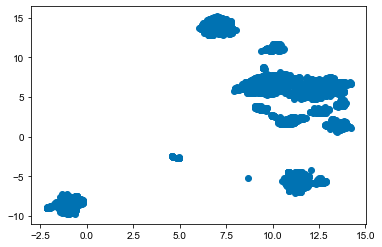

In [14]:
plt.scatter(umap_embedding[:,0],umap_embedding[:,1])

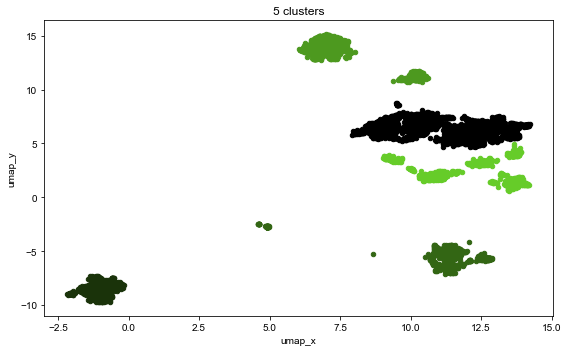

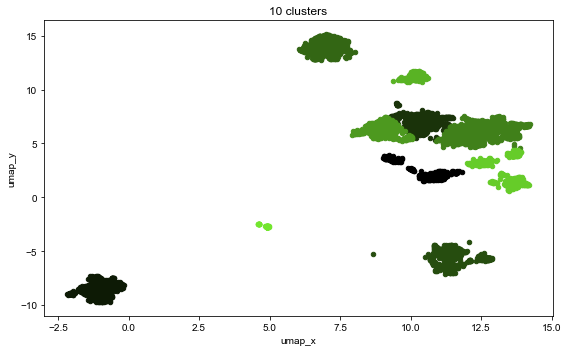

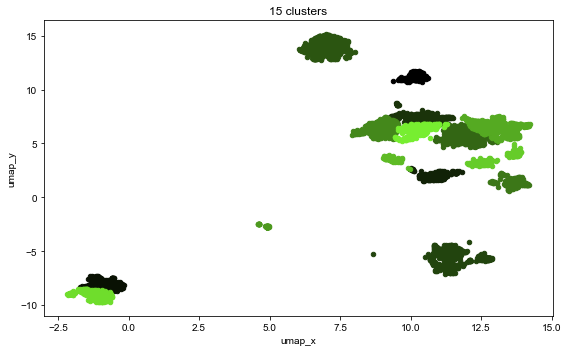

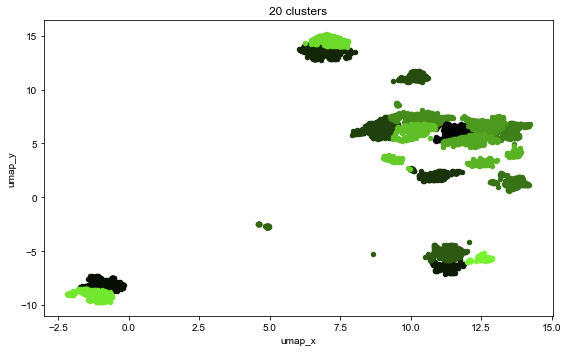

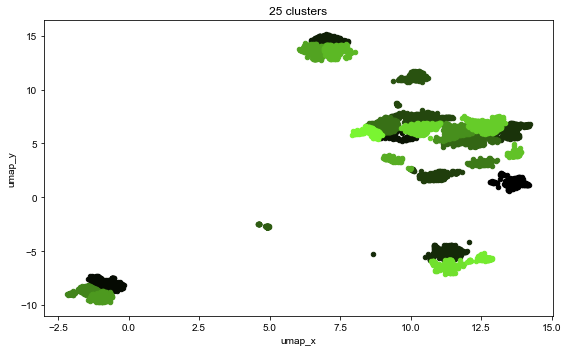

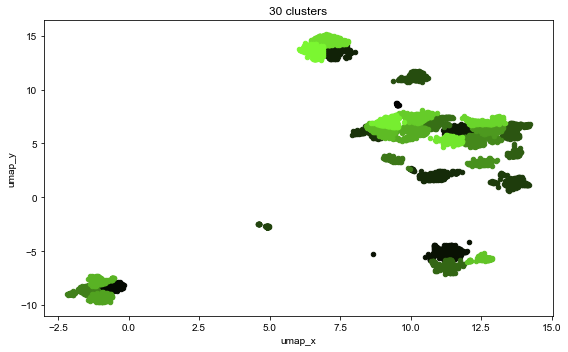

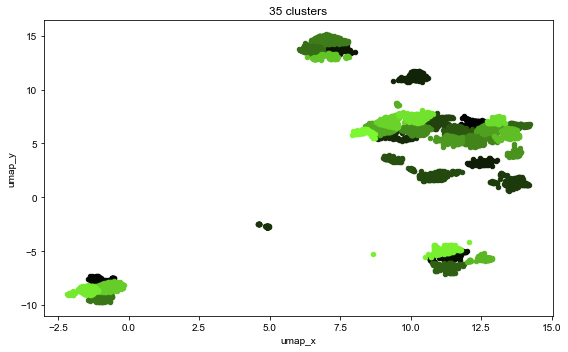

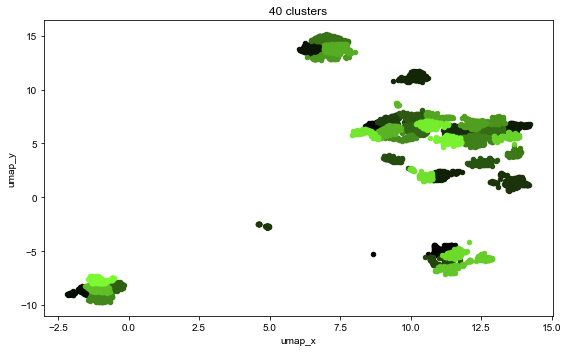

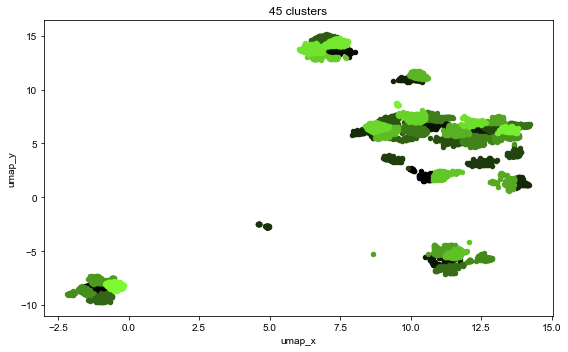

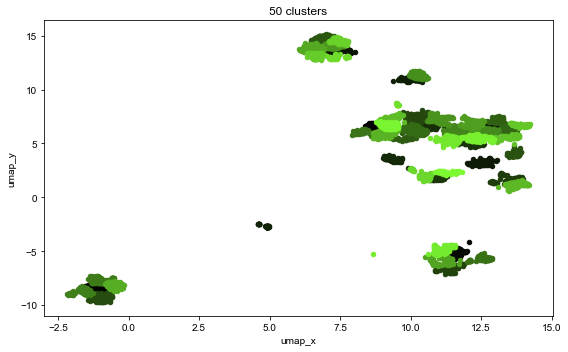

In [15]:
### elbow-ing UMAP
cluster_range = [5,10,15,20,25,30,35,40,45,50]
dfs_umap = []
save_to = os.path.join('C:/','Users','Michael Lee','1 Phage Display Data','K means clustering fixed rep')

distortions = {} 
inertias = {}

for n_clusters in cluster_range:
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    clusterer = Pipeline(
                [
                    ('kmeans',
                     KMeans(
                         n_clusters = n_clusters,
                         init = 'k-means++',
                         n_init = 50,
                         max_iter = 500,
                         random_state = SEED))])

    pipe = Pipeline(
                [
                    ('clusterer',clusterer)
                ])  

    out = pipe.fit(umap_embedding)

    rep_distortions = (sum(np.min(cdist(umap_embedding, out['clusterer']['kmeans'].cluster_centers_,
                                        'euclidean'), axis=1)) / umap_embedding.shape[0])
    rep_inertias = (out['clusterer']['kmeans'].inertia_)          
            
    clusters = out['clusterer'].transform(umap_embedding)
    labels = out['clusterer']['kmeans'].labels_
    groups = np.unique(labels)

    df_umap = pd.DataFrame()
    df_umap['umap_x'] = umap_embedding[:,0]
    df_umap['umap_y'] = umap_embedding[:,1]
    df_umap[f'umap label'] = labels
    dfs_umap.append(df_umap)

    for l in np.unique(labels):
        df_sub = df_umap.query(f'`umap label` == @l')
        df_sub.plot.scatter(x = 'umap_x', y = 'umap_y',color = (l/(2*n_clusters),l/n_clusters,l/(5*n_clusters),1),ax=ax)
    ax.set_title(f'{n_clusters} clusters')
    fig.tight_layout()
    try:
        plt.savefig(os.path.join(save_to,f'UMAP using {n_clusters} Clusters.png'),dpi = 300)
    except: 
        print('oopsie saving to wrong place')
    fig.show()

    distortions[n_clusters] = rep_distortions
    inertias[n_clusters] = rep_inertias

In [16]:
distortions

{5: 1.5031158980815316,
 10: 0.77897415282535,
 15: 0.5208743926090732,
 20: 0.40994316185832175,
 25: 0.3463736406262575,
 30: 0.3087788393042512,
 35: 0.2740251050623487,
 40: 0.24975159701425775,
 45: 0.23282979714342963,
 50: 0.22047669069503836}

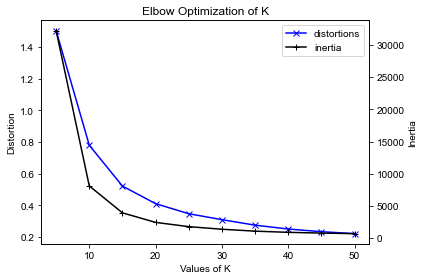

In [17]:
fig, ax = plt.subplots(1,1,figsize=(6,4))  

d = ax.plot(cluster_range, [distortions[n] for n in cluster_range], 'bx-',label='distortions')
ax.set_xlabel('Values of K')
ax.set_ylabel('Distortion')

ax2 = ax.twinx()
i = ax2.plot(cluster_range,[inertias[n] for n in cluster_range], 'k+-',label='inertia')
ax2.set_ylabel('Inertia')

lines = d + i
lb = [l.get_label() for l in lines]
plt.legend(lines,lb,loc='best')
plt.title(f'Elbow Optimization of K')

plt.tight_layout()
try:
    plt.savefig(os.path.join(save_to,f'Elbow Optimization.png'),dpi = 300)
except:
    print('oopsie saving to wrong place')

fig.show()

elbow is at about 15

In [18]:
# setup plotting 

import itertools

my_colorblind_colors = [(0.902,0.624,0),(0.337,0.706,0.914),(0,0.62,0.451),(0,0.447,0.698),(0.835,0.369,0),(0.8,0.475,0.655),(0.95,0.90,0.25)]
color_cycle = itertools.cycle(my_colorblind_colors)
cmap = my_colorblind_colors
j = 0
while len(my_colorblind_colors) < 50:
    if j == len(my_colorblind_colors):
        j = 0
    cmap.append(my_colorblind_colors[j])
    j = j+1
    
plt.style.use('seaborn-colorblind')
plt.rcParams["font.family"] = 'Arial'

In [22]:
help(df_sub)

Help on DataFrame in module pandas.core.frame object:

class DataFrame(pandas.core.generic.NDFrame, pandas.core.arraylike.OpsMixin)
 |  DataFrame(data=None, index: 'Optional[Axes]' = None, columns: 'Optional[Axes]' = None, dtype: 'Optional[Dtype]' = None, copy: 'bool' = False)
 |  
 |  Two-dimensional, size-mutable, potentially heterogeneous tabular data.
 |  
 |  Data structure also contains labeled axes (rows and columns).
 |  Arithmetic operations align on both row and column labels. Can be
 |  thought of as a dict-like container for Series objects. The primary
 |  pandas data structure.
 |  
 |  Parameters
 |  ----------
 |  data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
 |      Dict can contain Series, arrays, constants, dataclass or list-like objects. If
 |      data is a dict, column order follows insertion-order.
 |  
 |      .. versionchanged:: 0.25.0
 |         If data is a list of dicts, column order follows insertion-order.
 |  
 |  index : Index o

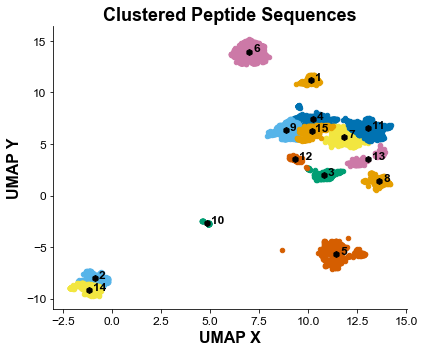

In [44]:
df_opt = dfs_umap[2]

fig,ax = plt.subplots(1,1,figsize=(6,5))
labels = np.unique(df_opt['umap label'].to_list())
for l in np.unique(labels):
    df_sub = df_opt.query('`umap label` == @l')
    df_sub.plot.scatter(x = 'umap_x', y = 'umap_y',color=my_colorblind_colors[l],ax=ax)
    x_sub = df_sub['umap_x'].to_list()
    y_sub = df_sub['umap_y'].to_list()
    ax.plot(np.average(x_sub),np.average(y_sub),'kh')
    ax.annotate(l+1,(np.average(x_sub)+0.2,np.average(y_sub)),weight='bold',fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(f'Clustered Peptide Sequences',fontsize=18,weight='bold')
ax.set_xlabel('UMAP X',fontsize = 16,weight='bold')
ax.set_ylabel('UMAP Y',fontsize = 16,weight='bold')
ax.tick_params(axis='both',labelsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_to,'UMAP Clusters Numbered.png'),dpi=300)
fig.show()

In [45]:
data_filtered['umap x'] = df_opt['umap_x']
data_filtered['umap y'] = df_opt['umap_y']
data_filtered['umap label'] = df_opt['umap label']

14


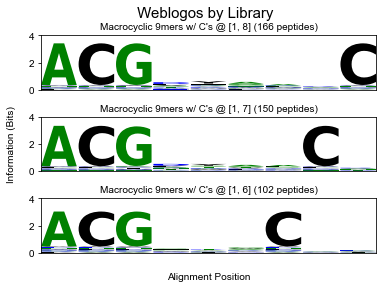

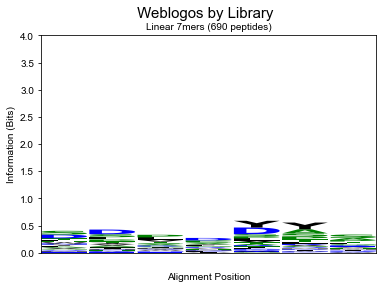

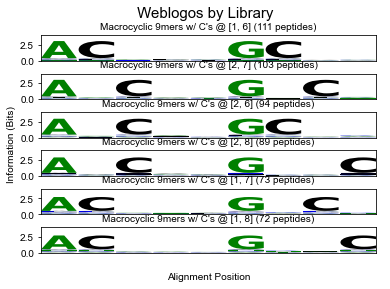

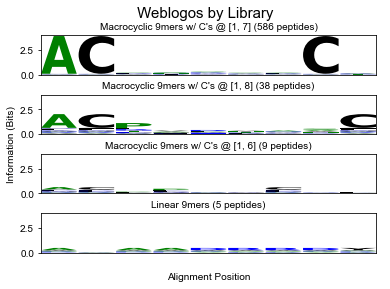

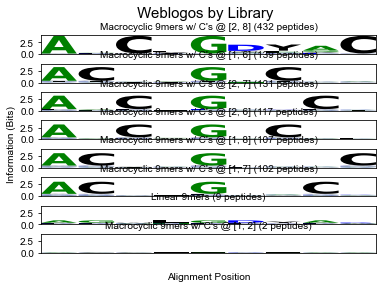

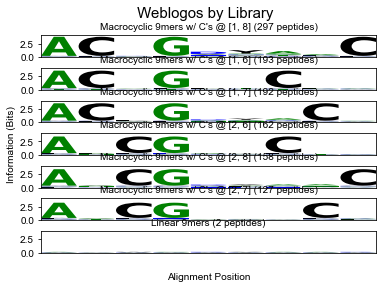

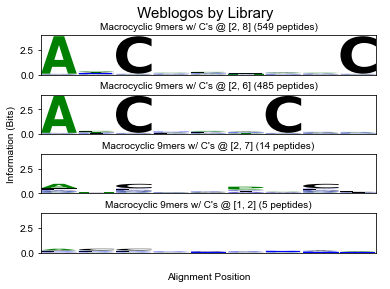

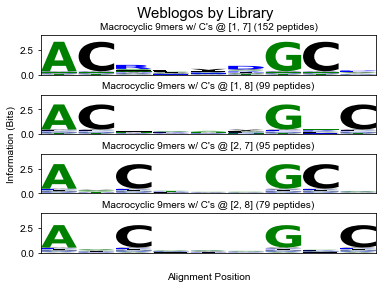

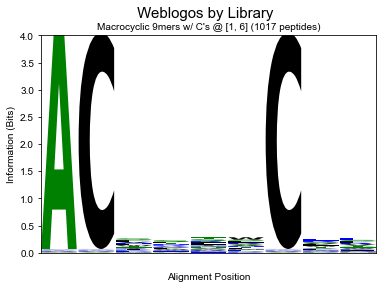

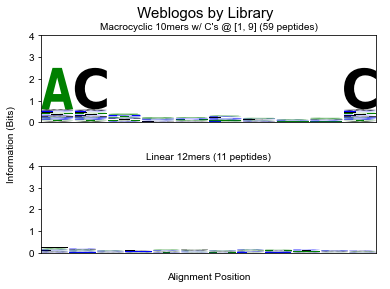

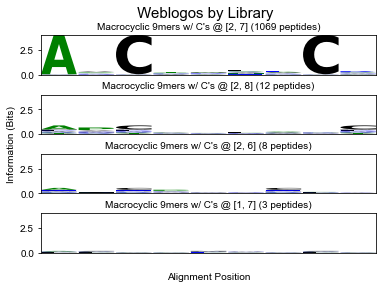

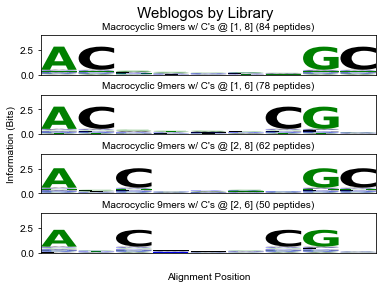

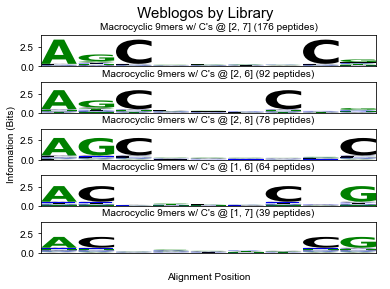

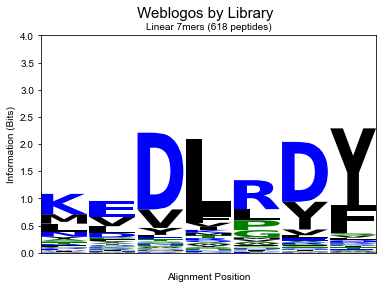

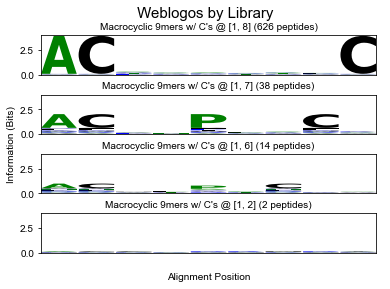

In [32]:
save_to = os.path.join('C:/','Users','Michael Lee','1 Phage Display Data','K means clustering fixed rep')

clusters = np.unique(df_opt['umap label'].to_list())
print(max(clusters))
for cluster in clusters:
    sub_lib = data_filtered.query('`umap label` == @cluster')
    generate_weblogos_by_library(sub_lib,'',f'Cluster {cluster + 1}',save_to)

### Now using ER score

In [46]:
save_to = os.path.join('C:/','Users','Michael Lee','1 Phage Display Data','K means clustering fixed rep','Color by label')

In [47]:
## get hits for overlay

peps = data_filtered['Peptide'].to_list()
motif_12ca5 = [hit.seq_contains_12ca5_motif(p) for p in peps]
motif_MDM2 = [hit.seq_contains_mdm2_motif(p) for p in peps]
data_filtered['12ca5 Motif'] = motif_12ca5
data_filtered['MDM2 Motif'] = motif_MDM2

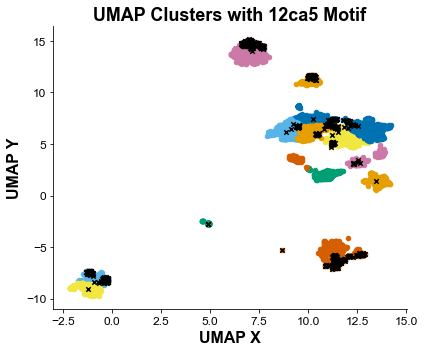

In [48]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
labels = np.unique(df_opt['umap label'].to_list())
for l in np.unique(labels):
    df_sub = df_opt.query('`umap label` == @l')
    df_sub.plot.scatter(x = 'umap_x', y = 'umap_y',color=my_colorblind_colors[l],ax=ax)
hits = data_filtered[data_filtered[f'12ca5 Motif']]
hits.plot.scatter(x = 'umap x', y = 'umap y', color = 'black', marker='x',ax = ax)
ax.set_title(f'UMAP of Data with Clusters')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(f'UMAP Clusters with 12ca5 Motif',fontsize=18,weight='bold')
ax.set_xlabel('UMAP X',fontsize = 16,weight='bold')
ax.set_ylabel('UMAP Y',fontsize = 16,weight='bold')
ax.tick_params(axis='both',labelsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_to,'UMAP Clusters 12ca5 motif overlay.png'),dpi=300)
fig.show()

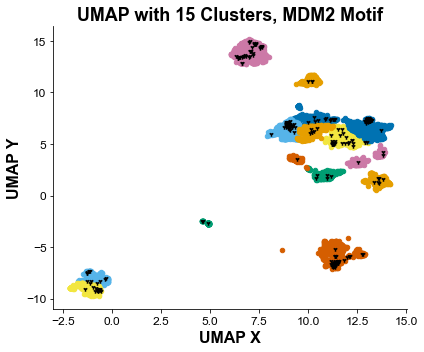

In [49]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
labels = np.unique(df_opt['umap label'].to_list())
for l in np.unique(labels):
    df_sub = df_opt.query('`umap label` == @l')
    df_sub.plot.scatter(x = 'umap_x', y = 'umap_y',color=my_colorblind_colors[l],ax=ax)
hits = data_filtered[data_filtered[f'MDM2 Motif']]
hits.plot.scatter(x = 'umap x', y = 'umap y', color = 'black', marker='1',ax = ax)
ax.set_title(f'UMAP of Data with Clusters')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(f'UMAP with 15 Clusters, MDM2 Motif',fontsize=18,weight='bold')
ax.set_xlabel('UMAP X',fontsize = 16,weight='bold')
ax.set_ylabel('UMAP Y',fontsize = 16,weight='bold')
ax.tick_params(axis='both',labelsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_to,'UMAP Clusters MDM2 motif overlay.png'),dpi=300)
fig.show()

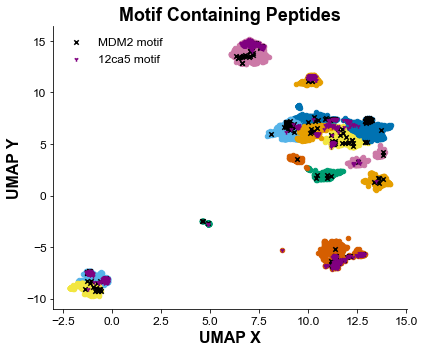

In [79]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
labels = np.unique(df_opt['umap label'].to_list())
for l in np.unique(labels):
    df_sub = df_opt.query('`umap label` == @l')
    df_sub.plot.scatter(x = 'umap_x', y = 'umap_y',color=my_colorblind_colors[l],ax=ax)
hits = data_filtered[data_filtered[f'MDM2 Motif']]
hits.plot.scatter(x = 'umap x', y = 'umap y', color = 'black',marker='x', ax = ax,label='MDM2 motif')
hits2 = data_filtered[data_filtered[f'12ca5 Motif']]
hits2.plot.scatter(x = 'umap x', y = 'umap y', color = 'purple',marker='1', ax = ax,label='12ca5 motif')

ax.legend(loc='upper left',frameon=False,fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(f'Motif Containing Peptides',fontsize=18,weight='bold')
ax.set_xlabel('UMAP X',fontsize = 16,weight='bold')
ax.set_ylabel('UMAP Y',fontsize = 16,weight='bold')
ax.tick_params(axis='both',labelsize=12)
fig.tight_layout()
plt.savefig(os.path.join(save_to,'UMAP Clusters Both motif overlay.png'),dpi=300)
fig.show()

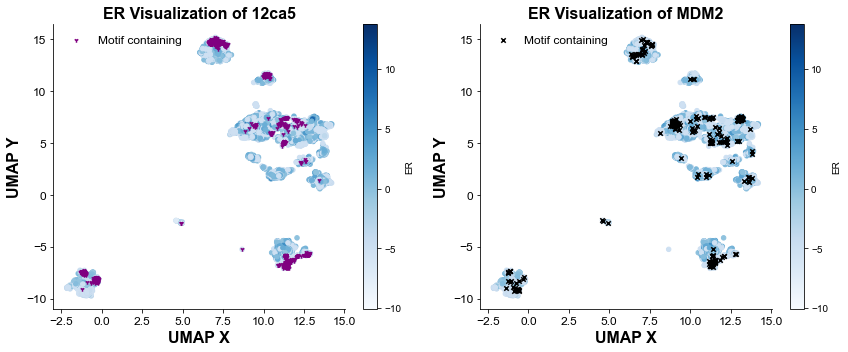

In [80]:
## color based on ER 

fig, axs = plt.subplots(1,2,figsize=(12,5))
prots = ['12ca5','MDM2']
markers = ['1','x']
mark_col = ['purple','black']
s = 5

for prot,ax,marker,c in zip(prots,fig.axes,markers,mark_col):
    plot = data_filtered.plot.scatter(x = 'umap x', y = 'umap y', c = 'ER',colormap = 'Blues',ax=ax)
    hits = data_filtered[data_filtered[f'{prot} Motif']]
    plot2 = hits.plot.scatter(x = 'umap x', y = 'umap y', c = c, marker=marker,ax=ax,label = 'Motif containing')
    ax.legend(loc='upper left',frameon=False,fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'ER Visualization of {prot}',fontsize=16,weight='bold')
    ax.set_xlabel('UMAP X',fontsize=16,weight='bold')
    ax.set_ylabel('UMAP Y',fontsize=16,weight='bold')
    ax.tick_params(axis='both',labelsize=12)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ind ER.png'),dpi = 300)
fig.show()

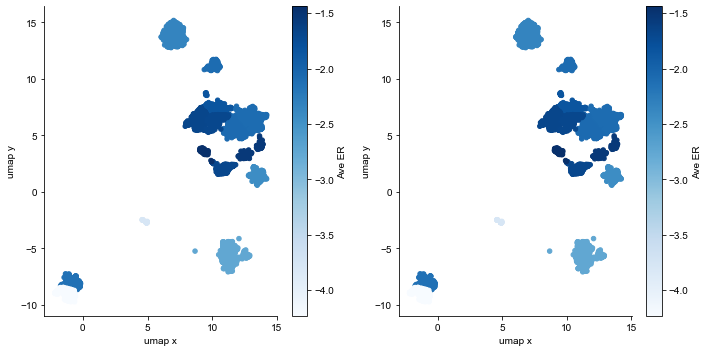

In [81]:
## color based on average in cluster

fig,axs = plt.subplots(1,2,figsize=(10,5))
for i,ax in enumerate(fig.axes):
    labels = np.unique(data_filtered['umap label'].to_list())
    df_aves = pd.DataFrame()
    for l in labels:
        df_sub = data_filtered.query('`umap label` == @l')
        ave_ER = df_sub['ER'].mean()
        df_sub['Ave ER'] = ave_ER
        df_aves = pd.concat([df_aves,df_sub])
    df_aves.plot.scatter(x = 'umap x', y = 'umap y', c = 'Ave ER', colormap = 'Blues',ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ave ER.png'),dpi = 300)
fig.show()

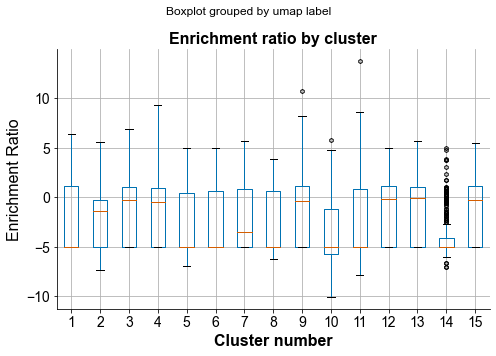

In [91]:
fig, axs = plt.subplots(1,1,figsize=(7,5),sharey=True)
for ax,prot in zip(fig.axes,prots):
    data_filtered.boxplot(column='ER',by='umap label',ax=ax,
               flierprops={'marker': 'h', 'markersize': 4})
    labels  = np.unique(data_filtered['umap label'].to_list())
    labels_fixed = [l+1 for l in labels]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Cluster number',fontsize=16,weight='bold')
    ax.set_title(f'Enrichment ratio by cluster',fontsize=16,weight='bold')
    ax.set_xticklabels(labels_fixed,rotation=0,horizontalalignment='center',fontsize=14)
axs.set_ylabel('Enrichment Ratio',fontsize=16)
axs.tick_params(axis='y',labelsize=14)
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Box and Whisker by ER.png'),dpi = 300)

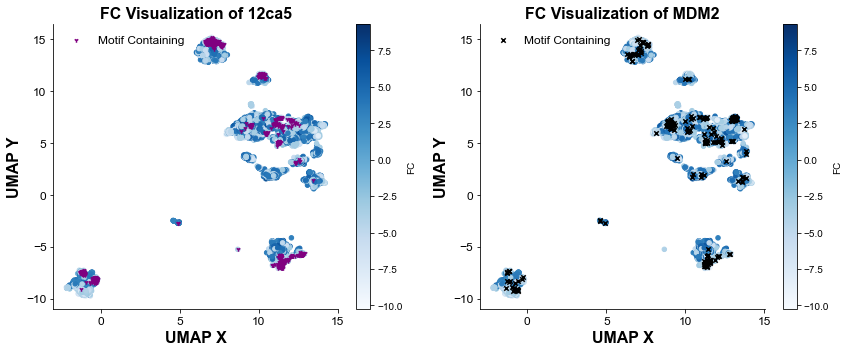

In [83]:
## color based on FC 

fig, axs = plt.subplots(1,2,figsize=(12,5))
prots = ['12ca5','MDM2']
# s = 3

for prot,ax,marker,c in zip(prots,fig.axes,markers,mark_col):
    plot = data_filtered.plot.scatter(x = 'umap x', y = 'umap y', c = 'FC',colormap = 'Blues',ax=ax)
    hits = data_filtered[data_filtered[f'{prot} Motif']]
    plot2 = hits.plot.scatter(x = 'umap x', y = 'umap y', c = c, marker=marker,ax=ax,label='Motif Containing')
    ax.legend(loc='upper left',frameon=False,fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'FC Visualization of {prot}',fontsize=16,weight='bold')
    ax.set_xlabel('UMAP X',fontsize=16,weight='bold')
    ax.set_ylabel('UMAP Y',fontsize=16,weight='bold')
    ax.tick_params(axis='both',labelsize=12)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ind FC.png'),dpi = 300)
fig.show()

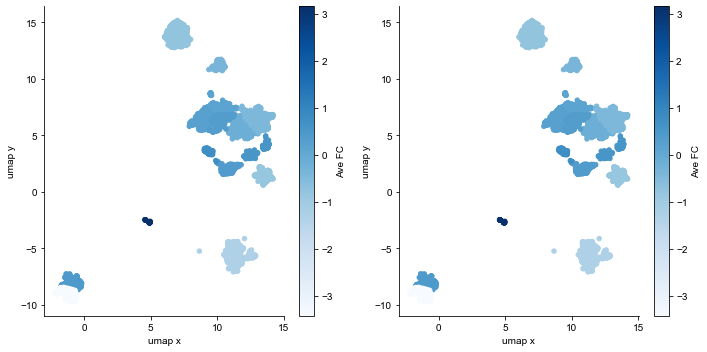

In [84]:
## color based on average in cluster

fig,axs = plt.subplots(1,2,figsize=(10,5))
for i,ax in enumerate(fig.axes):
    labels = np.unique(data_filtered['umap label'].to_list())
    df_aves = pd.DataFrame()
    for l in labels:
        df_sub = data_filtered.query('`umap label` == @l')
        ave_ER = df_sub['FC'].mean()
        df_sub['Ave FC'] = ave_ER
        df_aves = pd.concat([df_aves,df_sub])
    df_aves.plot.scatter(x = 'umap x', y = 'umap y', c = 'Ave FC', colormap = 'Blues',ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ave FC.png'),dpi = 300)
fig.show()

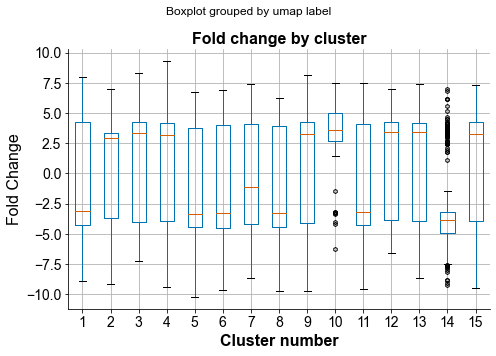

In [92]:
fig, axs = plt.subplots(1,1,figsize=(7,5),sharey=True)
for ax,prot in zip(fig.axes,prots):
    data_filtered.boxplot(column='FC',by='umap label',ax=ax,
               flierprops={'marker': 'h', 'markersize': 4})
    labels  = np.unique(data_filtered['umap label'].to_list())
    labels_fixed = [l+1 for l in labels]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Cluster number',fontsize=16,weight='bold')
    ax.set_title(f'Fold change by cluster',fontsize=16,weight='bold')
    ax.set_xticklabels(labels_fixed,rotation=0,horizontalalignment='center',fontsize=14)
axs.set_ylabel('Fold Change',fontsize=16)
axs.tick_params(axis='y',labelsize=14)
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Box and Whisker by FC.png'),dpi = 300)

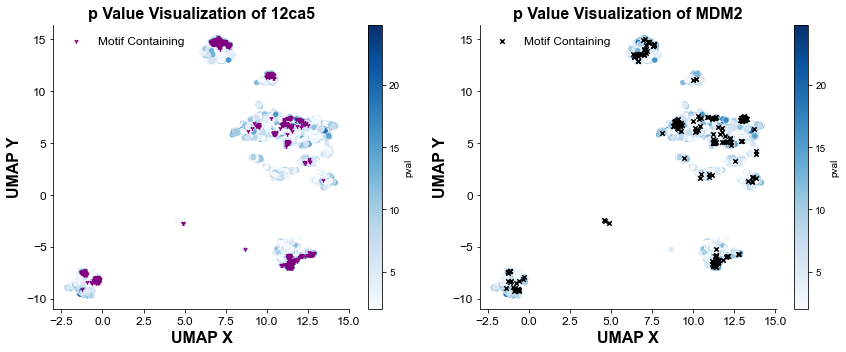

In [86]:
## color based on p value

fig, axs = plt.subplots(1,2,figsize=(12,5))
prots = ['12ca5','MDM2']
# s = 3

for prot,ax,marker,c in zip(prots,fig.axes,markers,mark_col):
    plot = data_filtered.plot.scatter(x = 'umap x', y = 'umap y', c = 'pval',colormap = 'Blues',ax=ax)
    hits = data_filtered[data_filtered[f'{prot} Motif']]
    plot2 = hits.plot.scatter(x = 'umap x', y = 'umap y', c = c, marker=marker,ax=ax,label='Motif Containing')
    ax.legend(loc='upper left',frameon=False,fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'p Value Visualization of {prot}',fontsize=16,weight='bold')
    ax.set_xlabel('UMAP X',fontsize=16,weight='bold')
    ax.set_ylabel('UMAP Y',fontsize=16,weight='bold')
    ax.tick_params(axis='both',labelsize=12)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ind pval.png'),dpi = 300)
fig.show()

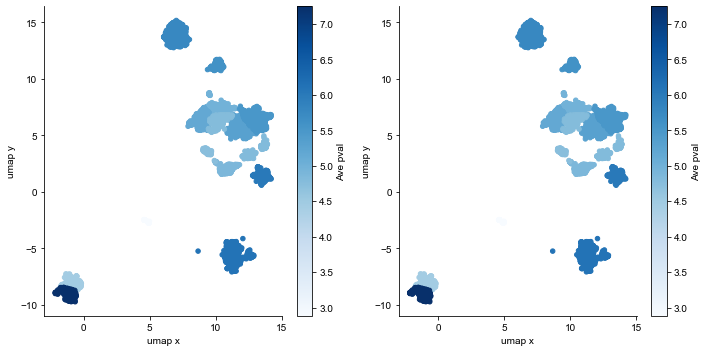

In [87]:
## color based on average in cluster

fig,axs = plt.subplots(1,2,figsize=(10,5))
for i,ax in enumerate(fig.axes):
    labels = np.unique(data_filtered['umap label'].to_list())
    df_aves = pd.DataFrame()
    for l in labels:
        df_sub = data_filtered.query('`umap label` == @l')
        ave_ER = df_sub['pval'].mean()
        df_sub['Ave pval'] = ave_ER
        df_aves = pd.concat([df_aves,df_sub])
    df_aves.plot.scatter(x = 'umap x', y = 'umap y', c = 'Ave pval', colormap = 'Blues',ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Clusters Colored by Ave pval.png'),dpi = 300)
fig.show()

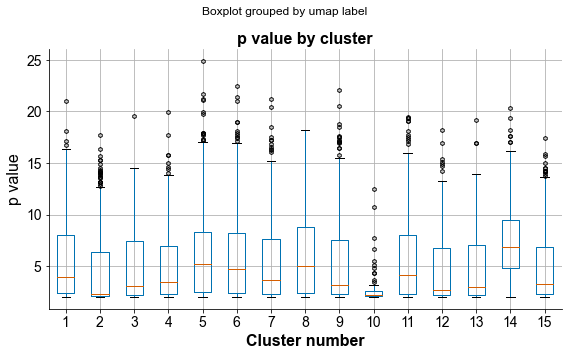

In [88]:
fig, axs = plt.subplots(1,1,figsize=(8,5),sharey=True)
for ax,prot in zip(fig.axes,prots):
    data_filtered.boxplot(column='pval',by='umap label',ax=ax,
               flierprops={'marker': 'h', 'markersize': 4})
    labels  = np.unique(data_filtered['umap label'].to_list())
    labels_fixed = [l+1 for l in labels]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Cluster number',fontsize=16,weight='bold')
    ax.set_title(f'p value by cluster',fontsize=16,weight='bold')
    ax.set_xticklabels(labels_fixed,rotation=0,horizontalalignment='center',fontsize=14)
axs.set_ylabel('p value',fontsize=16)
axs.tick_params(axis='y',labelsize=14)
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'Box and Whisker by pval.png'),dpi = 300)

## Highlight motif containing peps

In [53]:
dfs_umap_ER[0]

,umap_x,umap_y,label,ER,FC,log pval,Peptide,12ca5 Motif,MDM2 Motif
0,43.042690,2.543592,13,2.825214,9.075779,14.679381,KEDLRDY,False,False
1,42.497585,1.768727,13,2.306266,9.185657,13.598929,SDVYDYS,True,False
2,-0.127019,6.182004,9,6.193776,9.416169,15.774295,ACAADRRDY,False,False
3,-2.365220,8.031205,7,3.493759,9.477667,15.576672,APCFHLECR,False,False
4,-2.299886,8.250595,7,4.655582,8.939896,15.995751,AICRGDYAC,True,False
...,...,...,...,...,...,...,...,...,...
5482,42.687263,2.284135,13,-1.038368,3.091042,6.122882,KEDLRYV,False,False
5483,42.693619,2.276960,13,-1.038368,3.091042,3.693042,LLVLRDY,False,False
5484,41.642048,1.741165,1,-1.038368,3.091042,3.250905,LLDLLYV,False,False
5485,-2.557632,8.528331,7,-1.105482,3.044522,3.940332,AKCFVDYAC,True,True


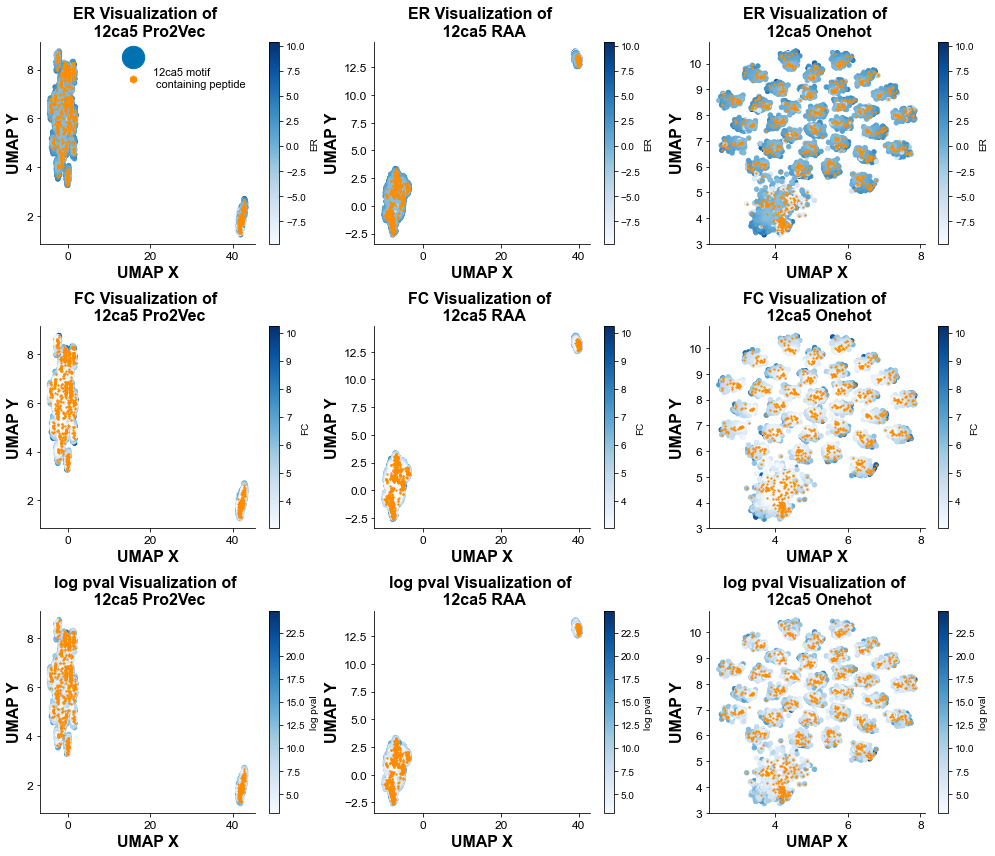

In [74]:
## color based on FC
rep_list_names = ['12ca5 Pro2Vec','12ca5 RAA','12ca5 Onehot']
metrics = ['ER','FC','log pval']

cols = 3
rows = 3

fig_hits = [a.query('`12ca5 Motif` == True') for a in dfs_umap_ER[0:3]]
s = 2

fig, axs = plt.subplots(rows,cols,figsize=(14,12))
for i in range(rows):
    lib = dfs_umap_ER[i]
    hits = fig_hits[i]
    for j in range(cols):
        lib.plot.scatter(x = 'umap_x', y = 'umap_y', c = metrics[j],colormap = 'Blues',ax=axs[j,i])
        hits.plot.scatter(x = 'umap_x', y = 'umap_y', c = 'darkorange', s=s, marker='h', ax=axs[j,i])
        axs[j,i].spines['right'].set_visible(False)
        axs[j,i].spines['top'].set_visible(False)
        axs[j,i].set_title(f'{metrics[j]} Visualization of \n {rep_list_names[i]}',fontsize=16,weight='bold')
        axs[j,i].set_xlabel('UMAP X',fontsize=16,weight='bold')
        axs[j,i].set_ylabel('UMAP Y',fontsize=16,weight='bold')
        axs[j,i].tick_params(axis='both',labelsize=12)

axs[0,0].legend(['','12ca5 motif \n containing peptide'],loc='best',frameon=False,fontsize=11,markerscale=5)
fig.tight_layout()
plt.savefig(os.path.join(save_to,f'12ca5 Clusters with Hit Overlay.png'),dpi = 300)
fig.show()